# Laplace equation
### Physics 481 Fall 2021 - Midterm exam

## Introduction
https://en.wikipedia.org/wiki/Laplace%27s_equation

In mathematics, Laplace's equation is a second-order partial differential equation named after Pierre-Simon Laplace who first studied its properties. This is often written as:

 $$ \nabla^{2}\varphi = 0 $$
 
where $\nabla^2$ is the Laplace operator (see below) and $\varphi$  is a scalar function.

Laplace's equation is one of the simplest examples of elliptic partial differential equations. The general theory of solutions to Laplace's equation is known as potential theory. Solutions of Laplace's equation are the harmonic functions, which are important in many fields of science, notably the fields of electromagnetism, astronomy, and fluid dynamics, because they can be used to accurately describe the behavior of electric, gravitational, and fluid potentials. In the study of heat conduction, the Laplace equation is the steady-state heat equation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Electrostatics
(eg. Chapter 3 "Introduction to Electrodynamics" by D. J. Griffiths)

The primary objective of electrostatics is to find the electric field produced by a given charge distribution.  In principle, this can be accomplished by evaluating Coulomb's law for some finite number $N$ of charges $q_n$

 $$ \vec E( \vec r) = \frac{1}{4\pi\epsilon_0} \sum_N q_n \frac{ \hat R}{R^2}  $$

where $\vec r$ is the field location, $\vec r'$ is the charge location, and

 $$ \vec R = \vec r - \vec r' $$

For a very large number of very small charges the sum can be replaced by an integral

 $$ \vec E( \vec r) =  \frac{1}{4\pi\epsilon_0} \int \frac{\hat R}{R^2} \rho(\vec r') d\tau' $$

of a continuous charge distribution that may vary as a function of position $r'$

  $$ \rho(\vec r') $$

Unfortunately, vector integrals of this type can be difficult to calculate for all but the simplest charge distributions.  Occasionally we can get around this by using Gauss's law and exploiting symmetry, but often the best strategy is to first calculate the potential, $V$, as defined by the somewhat more tractable scalar equation

 $$ V( \vec r) =  \frac{1}{4\pi\epsilon_0} \int \frac{1}{R} \rho(\vec r') d\tau $$ 
 
Still, even this single integral is often too tough to handle analytically.  Moreover, in problems involving conductors the charge distribution $\rho$ itself may not be known in advance.  Since charge is free to move around, the only thing we can control directly is the total charge (or perhaps the potential of each conductor).

In such cases, it can be useful to recast the problem in differential form, using Poisson's equation

  $$ \nabla^2 V = -\frac{\rho}{\epsilon_0} $$
  
We are often interested in finding the potential in a region where $\rho=0$.  For example, a capacitor with charges stored on conducting plates may create an electric field (aka potential gradient) in a charge-free region between the plates.   In this case, Poisson's equation reduces to Laplace's equation

  $$ \nabla^2 V = 0 $$
  
which is

  $$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} +  \frac{\partial^2 V}{\partial z^2} = 0 $$

in Cartesian coordinates.  Corresponding equations for other coordinate systems can be found in eg.

  https://en.wikipedia.org/wiki/Laplace_operator#Coordinate_expressions

## Laplace 1D

Consider a 1-dimensional system where $V(x)$ depends on only one variable, $x$.  Then Laplace's equation becomes

  $$ \frac{\partial^2 }{\partial x^2} V(x)= 0 $$  
  
Integrate once  
  
  $$ \frac{\partial}{\partial x} V(x)= a $$    
  
and again to get a general solution 

  $$ V(x) = a x + b $$
  
where $a$ and $b$ are constants which must satisfy the boundary conditions. 

### Differential to difference eqations
If we only consider discrete locations

  $$ x_i = i \Delta x $$

then we can approximate the first derivative with centered differences

  $$ \frac{\partial V}{\partial x}  \approx \frac{V(x_{i+1}) - V(x_{i-1})}{x_{i+1} - x_{i-1}} \approx \frac{V_{i+1} - V_{i-1}}{2 \Delta x} $$ 

and the second derivative as

$$ \frac{\partial^2 V}{\partial x^2}  \approx  \left . \frac{\partial V}{\partial x} \right |_{x_{i+1}} -  \left . \frac{\partial V}{\partial x} \right |_{x_i}
\approx 
\frac{V_{i+1} - 2V_i + V_{i-1}}{\Delta x^2}
$$
  
Laplace's equation on 1-d grid can then be written as

 $$  V_i = \frac{V_{i-1} + V_{i+1}}{2} $$
 
so that the potential at any given location should be equal to the average of the nearest neighbors.  This suggests that we might be able to use an iterative approach to solve for the potential profile.

### Numerical Recipe

To start: create an array to contain the potential values at some number $N$ of points.  Then set the first and last elements to match the boundary conditions.  Next, "sweep" through the array and replace every interior (non-boundary) value with the average of the two neighbors.  After some number of repeated sweeps the numerical solution should converge towards the physically correct value.

The two figures below shows some results from this approach.  After about 5000 iterations the numerical solution differs from the expected value by less than 1 millivolt.

It is worth looking at how the solution behaves for the first few steps, with information about the non-zero potential slowly diffusing away from the boundaries.  The relaxation method only communicates with neighboring points, so a large grid can take a long time to settle down to equilibrium.  This can be addressed using *multigrid* methods which use a combination of coarse and fine grids to make fast solutions with low accuracy and then refine them to achieve higher accuracy.

  ie. "An Analysis and Implementation of Multigrid Poisson Solvers With Verified Linear Complexity" https://www.ipol.im/pub/art/2018/228/article.pdf

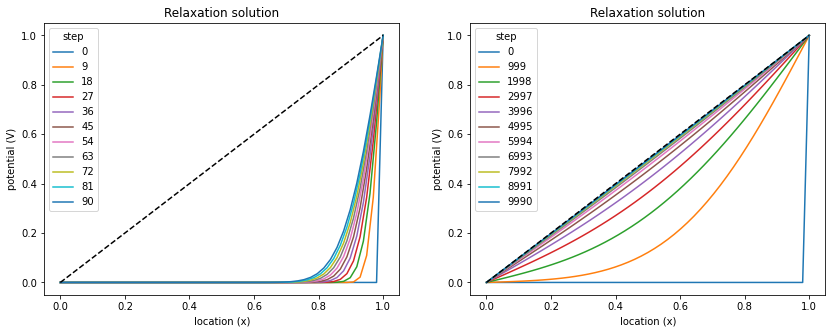

In [2]:
def plot_relaxation(nsteps=9999, axes=None):
    ''' solve 1-d laplace equation and show plots
    '''
    ax = plt.gca() if axes is None else axes
    
    x = np.linspace(0, 1.0, 99)  # evenly spaced locations along a line
    v = np.zeros( len(x) )       # potential at x locations

    # set lower/upper boundary conditions at x=0, 1 to 0, 1 volt
    v[0] , v[-1] = 0.0, 1.0

    # replace all internal points with average of neighbors
    #
    ## loopy equivalent:
    #
    #  oldv = v.copy()
    #  for i in range(1, len(x)-1):
    #      v[i] = ( oldv[i-1] + oldv[i+1] ) / 2.0
    #
    for indx in range(nsteps):
        v[1:-1] = (v[0:-2] + v[2:] ) / 2.0
    
    # make occasional plots
        if (indx % (nsteps//10) == 0): 
            ax.plot(x, v, label=str(indx))
        
    ax.legend(title='step')
    ax.set_xlabel('location (x)')
    ax.set_ylabel('potential (V)')
    ax.set_title('Relaxation solution')

    ax.plot(x, x, 'k--')  # expected value
  
fig, axes = plt.subplots(1,2, figsize=(14,5) )
plot_relaxation(99, axes=axes[0])
plot_relaxation(9999, axes=axes[1] )

Text(0.5, 1.0, 'Relaxation solution error')

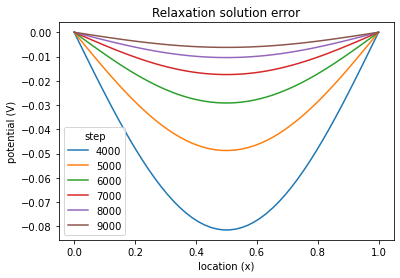

In [3]:
nsteps = 9999
x = np.linspace(0, 1.0, 99)
v = np.zeros( len(x) )
v[0] , v[-1] = 0.0, 1.0
for indx in range(nsteps):
    v[1:-1] = (v[0:-2] + v[2:] ) /2.0
    if (indx > 3000 and indx % 1000 == 0): 
        plt.plot(x, v-x, label=str(indx))
plt.legend(title='step')
plt.xlabel('location (x)')
plt.ylabel('potential (V)')
plt.title('Relaxation solution error')

### Task 1.1: 
Write python code to solve Laplace's equation in 1-dimension for V(x=0)=0 and V(x=1)=1.  Compare numerical results with the analytic theoretical solution.

## Laplace 2D

In two dimensions, Laplace's equation reduces to

  $$\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0 $$

We can replace continous spatial dimensions by using a lattice with finite spacing

  $$x_i = i \Delta x $$
  $$y_j = j \Delta y $$

and if $\Delta_x = \Delta_y$ then the potential at each point is given by the average at the four closest adjoining sites

 $$V(x_i, y_j) = V_{i,j} = \frac{V_{i-1,j} + V_{i+1,j} + V_{i,j-1} + V_{i,j+1}}{4} $$

### Griffiths example 3.4: 
Two infinitely long grounded metal plates lie parallel to the $x-z$ plane, one at $y=0$, the other at $y=a=5~cm$.  They are connected at $x=\pm b=\pm 4~cm$ by narrower metal strips maintained at a constant potential $V_0=4~volts$ to form a rectangular channel.  A thin layer of insulation at each corner allows the sides to be maintained at different potentials.

A solution to this boundary value problem can be obtained through separation of variables

  $$ V(x,y) = \frac{4 V_0}{\pi} \sum_{n=1,3,5,...} \frac{1}{n} \frac{\cosh(n \pi x / a)}{\cosh (n \pi b / a)} \sin(n \pi y / a)$$

### Task 2.1:
Obtain a numerical solution to Laplace's equation in 2D for Griffiths example 3.4 and compare to the analytic result.

### Task 3.1:
A coaxial cable has inner cylindrical conductor with radius of $r_a=1~mm$ and outer conductor radius of $r_b=5~mm$.  Assume that the outer conductor is grounded and the inner conductor is at potential $V_0=9~volts$.

Obtain a numerical solution to Laplace's equation in the region between the inner and outer conductors.  Plot and discuss.

### Task 3.2:
What is the potential midway between the inner and outer conductors (at $r=3~mm$)?  

## Supplemental material

### Finite differences

A real-valued function $f(x)$ can be approximated with a Taylor series near some point $x=a$

  $$f(a) + \frac{f'(a)}{1!} (x-a) + \frac{f''(a)}{2!} (x-a)^2 + \frac{f'''(a)}{3!} (x-a)^3 + \ldots$$
  
If we restrict our attention to a set of points equally spaced by $\Delta$ this becomes
  
  $$f_{i+n} = f(x_i) + f'(x_i) n\Delta + \frac{f''(x_i)}{2} (n\Delta)^2 + \frac{f'''(x_i)}{6} (n\Delta)^3 + O(\Delta^4)$$
  
  

For three adjacent points 

  $$\begin{aligned}
  f_{i+1} =& \;f(x_i) + f'(x_i) \Delta + \frac{f''(x_i)}{2} \Delta^2 + \frac{f'''(x_i)}{6} \Delta^3 + O(\Delta^4) \\
  f_i =& \;f(x_i)
  \\
  f_{i-1} =& \;f(x_i) - f'(x_i) \Delta + \frac{f''(x_i)}{2} \Delta^2 - \frac{f'''(x_i)}{6} \Delta^3 + O(\Delta^4)
  \end{aligned}$$ 

so we can subtract two neighboring points

  $$f_{i+1} - f_i = f'(x_i) \Delta + \frac{f''(x_i)}{2} \Delta^2 + \frac{f'''(x_i)}{6} \Delta^3 + O(\Delta^4)$$
  
to get an *forward difference* estimate of the first derivative  
  
  $$\frac{f_{i+1} - f_i}{\Delta} = f'(x_i)  + \frac{f''(x_i)}{2} \Delta + \frac{f'''(x_i)}{6} \Delta^2 + O(\Delta^3) \approx f'(x_i) + O(\Delta) $$
  

A similar approach gives a *backward difference* estimate of the slope
  $$f'(x_i)  \approx \frac{f_{i+1} - f_i}{\Delta} + O(\Delta) $$
  $$f'(x_i)  \approx \frac{f_{i} - f_{i-1}}{\Delta} + O(\Delta) $$

By subtracting $f_{i-1}$ from $f_{i+1}$ we can cancel all of the even terms (i.e. $f$, $f''$)

  $$f_{i+1} - f_{i-1} = 2 f'(x_i) \Delta + 2 \frac{f'''(a)}{6} \Delta^3 + O(\Delta^5)$$
  
and re-arrange to get an equation for the first *centered difference*
  
  $$\boxed{f'(x_i) \approx \frac{f_{i+1} - f_{i-1}}{2 \Delta} + O(\Delta^2)}$$

with error that is quadratic in $\Delta$.

By adding $f_{i-1}$ to $f_{i+1}$ we can cancel all of the odd terms (i.e. $f'$, $f'''$)

 $$f_{i+1} + f_{i-1} = 2 f(x_i) + f''(x_i) \Delta^2 + O(\Delta^2)$$
 
and obtain an expression for the centered second difference 
 
 $$\boxed{f''(x_i) \approx  \frac{f_{i+1} -2f_i + f_{i-1}}{\Delta^2} + O(\Delta^2)}$$ 
 
with error that also scales as $\Delta^2$.  This means that reducing the step size by a factor of 10 will reduce the error by a factor of 100.  Note, however that this will usually require $10\times$ more memory and processor time.

### Matrix methods

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

Expressing the continuous Laplace equation in 1-dimension with $N$ discrete points leads to a set of $N$ coupled linear equations.  These can be conveniently written using matrix notation.  For $N=6$ this involves this tridiagonal matrix

$$ \left[ \begin{matrix}
{1} & {} & {} & {} & {} & {} \\
{1} & {-2} & {1} & {} & {} & {} \\
{} & {1} & {-2} & {1} & {} & {} \\
{} & {} & {1} & {-2} & {1} & {} \\
{} & {} & {} & {1} & {-2} & {1} \\
{} & {} & {} & {} & {} & {1} 
\end{matrix} \right]
\left[ \begin{matrix}
V_0 \\ V_1 \\ V_2 \\ V_3 \\ V_4 \\ V_5
\end{matrix} \right]
=
\left[ \begin{matrix}
V_a \\ 0 \\ 0 \\ 0 \\ 0  \\ V_b
\end{matrix} \right]
$$

and a column matrix containing the boundary conditions $V_a$ and $V_b$.

In [5]:
def laplace1D_matrices(n=100):
    '''generate matrixes for 1-d Laplace equation
    
    **should probably use numpy.tri
    
    '''
    mat = np.zeros( (n,n), dtype=np.double)
    mat[0,0] = 1
    mat[-1,-1] = 1.0
    for i in range(1,n-1):
        mat[i,i-1] = 1
        mat[i,i] = -2
        mat[i,i+1] = 1
    
    vec = np.zeros(n)    
    vec[0] = 0.0
    vec[-1] = 1.0    

    return mat,vec

m,v = laplace1D_matrices(6)
print(m,v)

[[ 1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1.]] [0. 0. 0. 0. 0. 1.]


In [6]:
# Condition number gives indication of inversion stability
# 1 is perfect, 10-1000 is fine, 1e9 is trouble
#
np.linalg.cond(m)

10.994600319765407

In [7]:
# take a look at inverse
#
np.linalg.inv(m)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.8, -0.8, -0.6, -0.4, -0.2,  0.2],
       [ 0.6, -0.6, -1.2, -0.8, -0.4,  0.4],
       [ 0.4, -0.4, -0.8, -1.2, -0.6,  0.6],
       [ 0.2, -0.2, -0.4, -0.6, -0.8,  0.8],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])

In [8]:
# solve for the potential on a 1-d grid
# this should be linear between 0.0 and 1.0 volts.
#
np.matmul( np.linalg.inv(m), v)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

#### Solve, don't invert

For a set of linear equations $A x = b$ we may write the solution in terms of a matrix inverse $x = A^{-1} b$. However, this is not always the best way to proceed numerically if we are just interested in the solution and don't actually require the inverse.  

Instead, call a `solve` function which will usually give a result for $x$ that is more computationally efficient and numerically stable.

In [9]:
%timeit np.matmul( np.linalg.inv(m), v)
%timeit np.linalg.solve( m, v)
#%timeit np.linalg.solve_banded((1,1), m, v)
#?np.linalg.solve

7.01 µs ± 46.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.6 µs ± 84.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Sparse Linear Systems
NR p72 http://www.aip.de/groups/soe/local/numres/bookcpdf/c2-7.pdf

A system of linear equations is called *sparse* if only a relatively small number of its matrix elements $a_{ij}$ are nonzero.  It is wasteful to use general methods of linear algebra on such problems, because most of the $O(N^3)$ arithmetic operations devoted to solving the set of equations or inverting the matrix involve adding or multiplying by zeros.  Furthermore, you might wish to work problems so large as to tax your available memory space, and it is wasteful to reserve storage for large numbers of zeros.  Note that there are two distinct (and not always compatible) goals for any sparse matrix method: saving time and/or saving space.

See also: 

https://en.wikipedia.org/wiki/Sparse_matrix

https://www.sharcnet.ca/help/index.php/Solving_Systems_of_Sparse_Linear_Equations

http://hplgit.github.io/bumpy/doc/pub/lectures-basics-1.html#___sec28

In [10]:
# demonstrate how to convert a numpy ndarray to CSR format and back again
#
m, v = laplace1D_matrices(n=4)
s = scipy.sparse.csr_matrix(m)
assert( np.all( s.toarray() == m ) )

s

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [11]:
# compare sparse and full matrix storage requirements
#
#
stack = []
for n in [3,5,10,20,100,200,500,1000]:
    m, v = laplace1D_matrices(n)
    s = scipy.sparse.csr_matrix(m)
    stack.append( (n, m.size, s.count_nonzero() ) )

print(stack)

[(3, 9, 5), (5, 25, 11), (10, 100, 26), (20, 400, 56), (100, 10000, 296), (200, 40000, 596), (500, 250000, 1496), (1000, 1000000, 2996)]


Text(0.5, 0, 'array width,length')

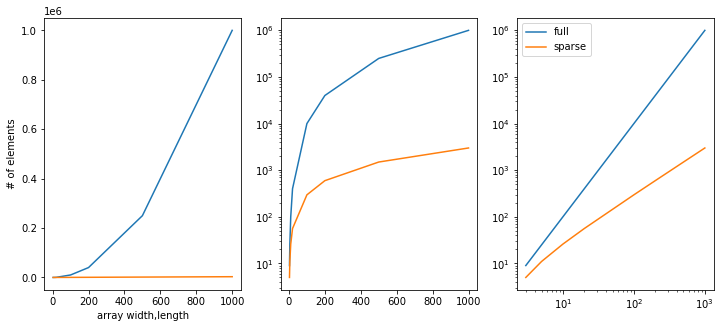

In [12]:
stack = np.array(stack)
fig, axes = plt.subplots(1,3, figsize=(12,5))
for indx,ax in enumerate(axes):
    ax.plot(stack[:,0], stack[:,1], label='full')
    ax.plot(stack[:,0], stack[:,2], label='sparse')
    if indx==2:
        ax.set_xscale('log')
    if indx >= 1:
        ax.set_yscale('log')
plt.legend( loc=0 )
axes[0].set_ylabel('# of elements')
axes[0].set_xlabel('array width,length')

In [13]:
m, v = laplace1D_matrices(n=100)
s = scipy.sparse.csr_matrix(m)

In [14]:
sparse.linalg.spsolve(s, v)[::9]

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091, 1.        ])

Even for a not very large array ($N=100$) the sparse solver is almost three times as fast as the full matrix approach.

In [15]:
%timeit scipy.linalg.solve(m, v)
%timeit sparse.linalg.spsolve(s, v)

110 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
71.7 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
[name for name in dir(scipy.linalg) if 'solve' in name]

['_solve_toeplitz',
 '_solvers',
 'cho_solve',
 'cho_solve_banded',
 'lu_solve',
 'solve',
 'solve_banded',
 'solve_circulant',
 'solve_continuous_are',
 'solve_continuous_lyapunov',
 'solve_discrete_are',
 'solve_discrete_lyapunov',
 'solve_lyapunov',
 'solve_sylvester',
 'solve_toeplitz',
 'solve_triangular',
 'solveh_banded']